In [1]:
# BLOCO 1 - Importing Libraries

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import requests
# Instalação de bibliotecas necessárias (mantido do seu original)
!pip install kaggle tensorflow tensorflow_hub librosa matplotlib

# Instalação de bibliotecas necessárias
!pip install kaggle tensorflow tensorflow_hub librosa matplotlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam


In [2]:
# BLOCO 2 - CRIA DIRETÓRIOS E BAIXA JSON

# 1. Cria o diretório /content/kaggle
os.makedirs('/content/kaggle', exist_ok=True)
print("Diretório /content/kaggle criado com sucesso.")

# 2. Continua com a criação do diretório de configuração padrão do Kaggle (necessário)
# Se você ainda for usar a API do Kaggle para baixar dados, este diretório é essencial.
os.makedirs('/root/.kaggle', exist_ok=True)
print("Diretório /root/.kaggle criado para a chave de API.")

file_id = "1drlyKgvfvFaE69SzowRjcF5KK14jaroQ"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
dest_path = "/content/kaggle/kaggle.json"

response = requests.get(url)
if response.status_code == 200:
    with open(dest_path, "wb") as f:
        f.write(response.content)
    print("Arquivo JSON baixado com sucesso.")
else:
    print("Erro ao baixar o arquivo:", response.status_code)

!cp "{dest_path}" "/root/.kaggle"

# 3. Garante permissões (para o arquivo que estará em /root/.kaggle/kaggle.json)
# Este comando só terá efeito *depois* que o arquivo kaggle.json for copiado para lá.
!chmod 600 /content/kaggle/kaggle.json
!chmod 600 /root/.kaggle

# 1. Cria o diretório /content/kaggle
os.makedirs('/content/musical', exist_ok=True)
print("Diretório /content/musical criado com sucesso.")

# 2. Garante permissões (para o arquivo que estará em /root/musical)
# Este comando só terá efeito *depois* que o arquivo kaggle.json for copiado para lá.
!chmod 600 /content/musical


Diretório /content/kaggle criado com sucesso.
Diretório /root/.kaggle criado para a chave de API.
Arquivo JSON baixado com sucesso.
Diretório /content/musical criado com sucesso.


In [3]:
# BLOCO 3 - FAZ DOWNLOAD E DESCOMPACTA O ARQUIVO DO DATASET

import os

DATA_DIR = '/content/musical/'
DATASET_SLUG = 'soumendraprasad/musical-instruments-sound-dataset'
ZIP_FILE = os.path.join(DATA_DIR, 'musical-instruments-sound-dataset.zip')

# Baixa o dataset do Kaggle para o diretório
# Use 'f-string' para que a variável {DATASET_SLUG} seja impressa corretamente
print(f'Baixando dataset {DATASET_SLUG}...')
!kaggle datasets download -d {DATASET_SLUG} -p {DATA_DIR}

# Descompacta o arquivo ZIP
print('Descompactando arquivos...')
# O '-q' é para modo quieto
!unzip -q {ZIP_FILE} -d {DATA_DIR}

print('Download e descompactação concluídos.')

Baixando dataset soumendraprasad/musical-instruments-sound-dataset...
Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/musical-instruments-sound-dataset
License(s): CC0-1.0
100% 5.38G/5.40G [01:23<00:00, 246MB/s]
100% 5.40G/5.40G [01:23<00:00, 69.7MB/s]
Descompactando arquivos...
Download e descompactação concluídos.


Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64


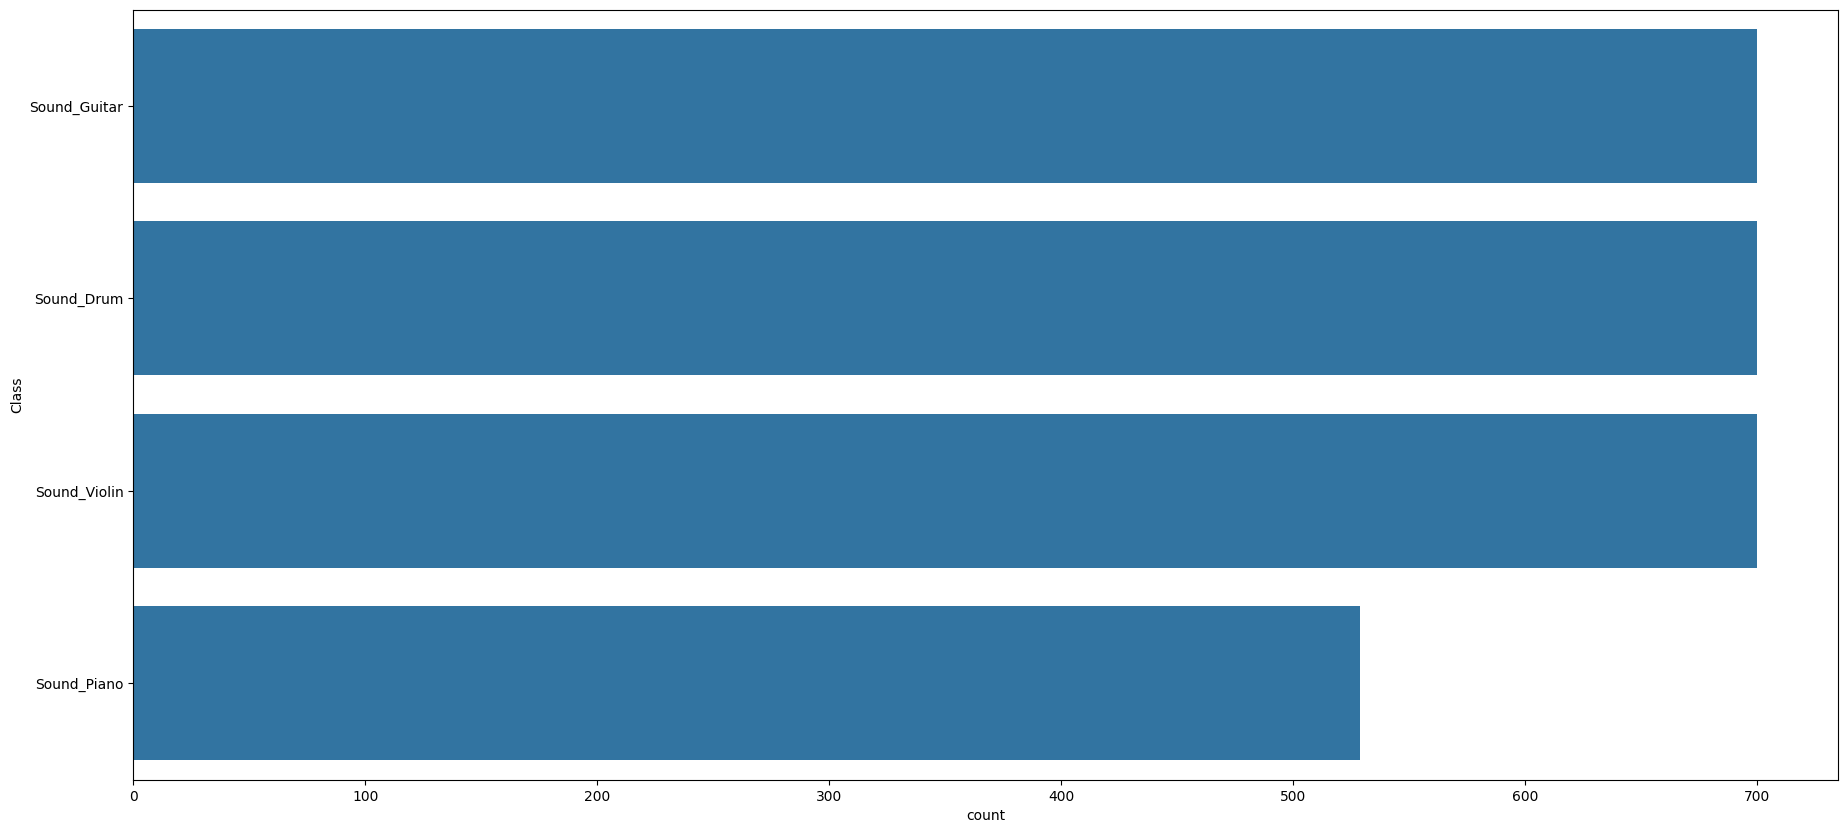

Class
Sound_Guiatr    20
Sound_Drum      20
Sound_Violin    20
Sound_Piano     20
Name: count, dtype: int64


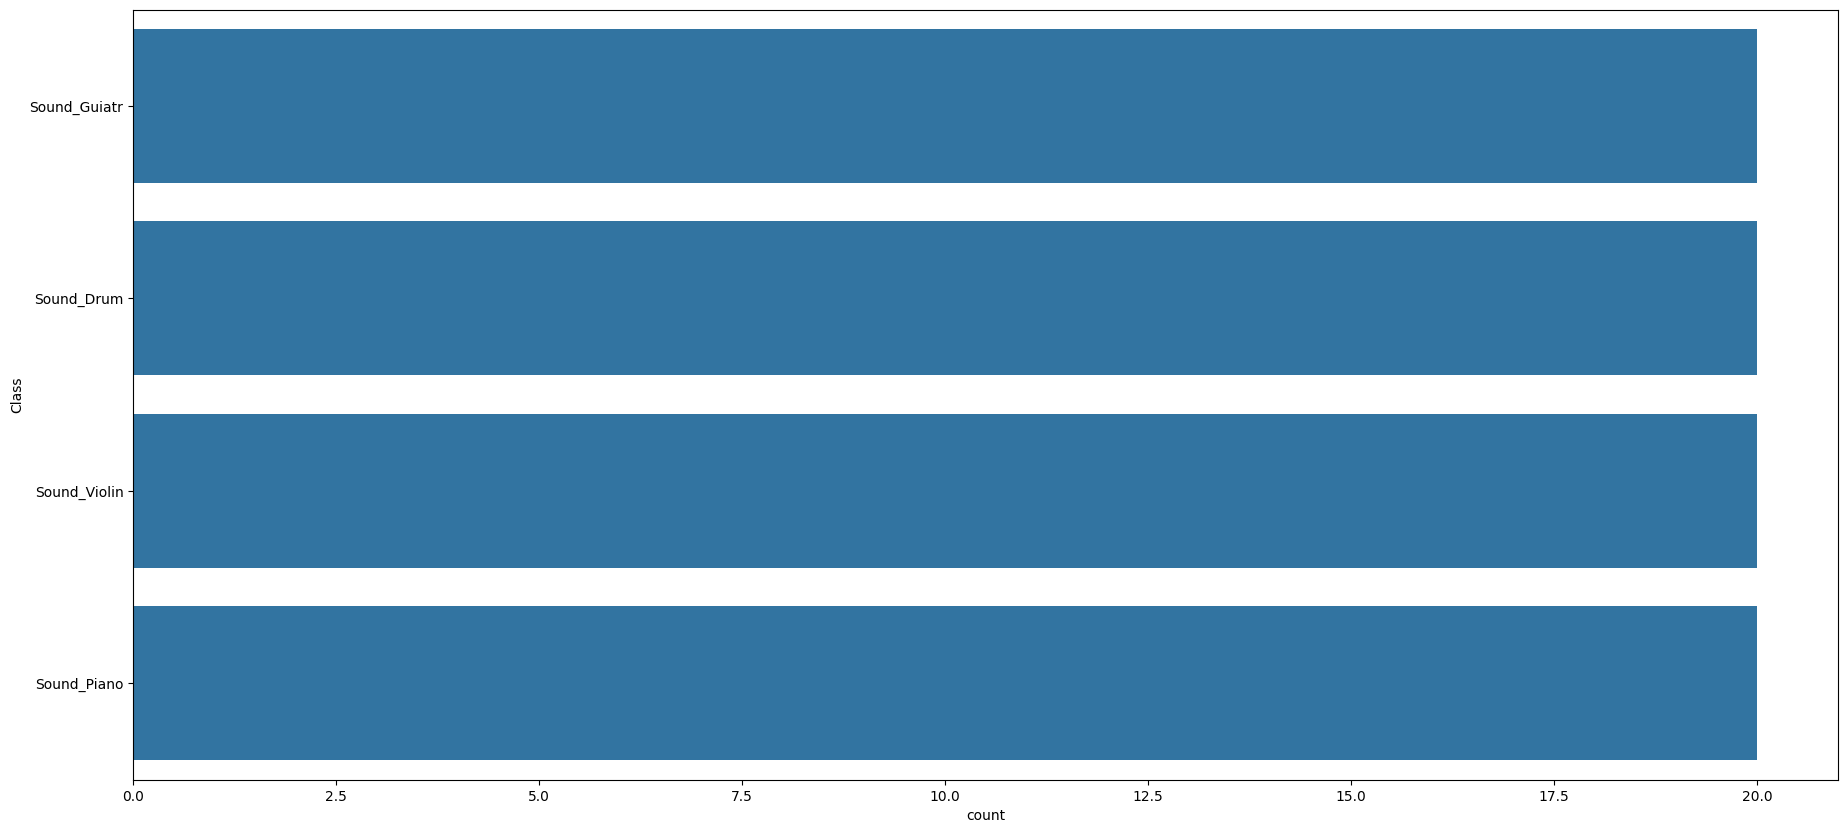

In [4]:
# BLOCO 4 - VALIDA CSV - ABRE E VE O CONTEUDO
# Exploring csv Files

df=pd.read_csv("/content/musical/Metadata_Train.csv")
df2=pd.read_csv("/content/musical/Metadata_Test.csv")

df

# Visualizing Tag column

print(df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df['Class'])
plt.xticks(rotation=0)

plt.show()

print(df2['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df2['Class'])
plt.xticks(rotation=0)

plt.show()

Feature_extractor definida para 120 features (40 MFCCs + Delta + Delta-Delta).
Iniciando extração de features e duração (120 dimensões)...
Tempo total de processamento: 334.21 segundos.
Total de arquivos com METADADOS e DURAÇÃO válidos no DataFrame final: 3329
Total de FEATURES (X) extraídas com sucesso: 3329 amostras de 120 dimensões.
Total de RÓTULOS (y) extraídos com sucesso: 3329 rótulos.


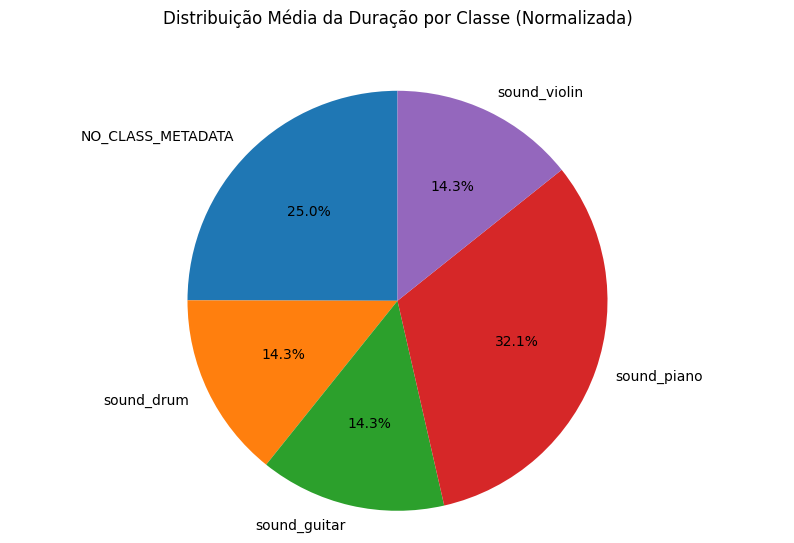

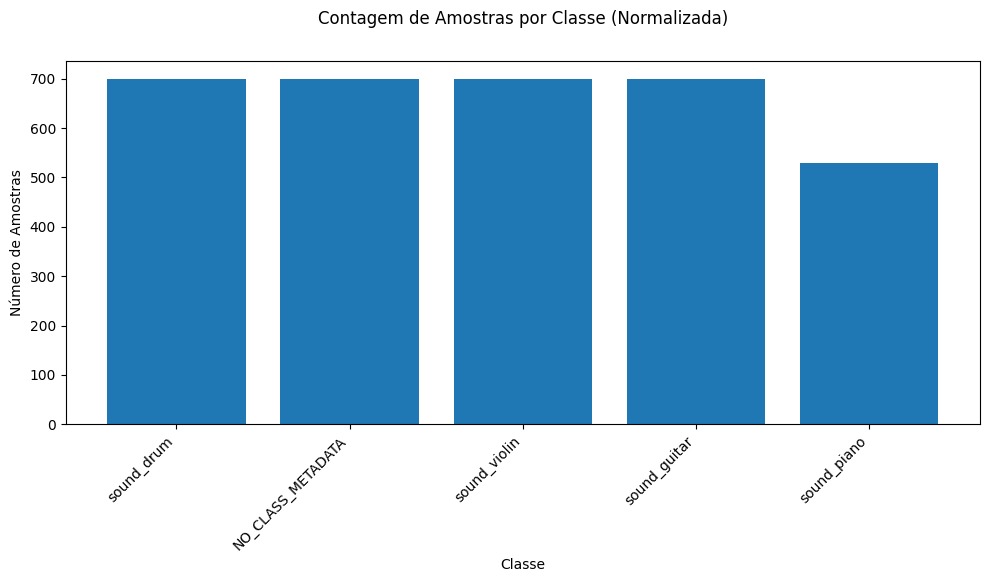


TABELA DE RESUMO E ESTATÍSTICAS INICIAIS (Classes Normalizadas)
                   count  avg_length  min_length  max_length
Class                                                       
NO_CLASS_METADATA    700   24.995616    4.014000      60.000
sound_drum           700   14.304025    1.058639     128.064
sound_guitar         700   14.341907    1.444762      82.000
sound_violin         700   14.304025    1.058639     128.064
sound_piano          529   32.187041    2.328000     124.440

DataFrame de Metadados Processado salvo como 'df_processed.csv' para o Bloco 6.
Arrays X (Features) e y (Rótulos) salvos em 'features_X.npy' e 'labels_y.npy' para o Bloco 6.


In [29]:
# BLOCO 5 - CARREGA METADATA DOS ARQUIVOS, MESCLA, PROCESSA, CALCULA, ANALISA, VISUALIZA E GERA TABELA RESUMO

import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. DEFINIÇÃO DE CONSTANTES
# ==============================================================================
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'
ARQUIVO_CSV = "/content/musical/Metadata_Train.csv"
METADADOS_PATH_OUT = 'df_processed.csv'
FEATURES_PATH_OUT = 'features_X.npy'
LABELS_PATH_OUT = 'labels_y.npy'

# CONSTANTE PARA NORMALIZAÇÃO DE VALORES DESCONHECIDOS
CLASSE_DESCONHECIDA = 'NO_CLASS_METADATA'

# CONSTANTES PARA EXTRAÇÃO DE FEATURES
N_MFCC = 40
MAX_PAD_LEN = 40
# ==============================================================================
# 2. FUNÇÃO FEATURE EXTRACTOR (MFCCs, Delta, Delta-Delta)
# ==============================================================================

def Feature_extractor(filename, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    """Extrai 120 features (MFCCs, Delta, Delta-Delta) de um arquivo de áudio."""
    try:
        # 1. Carrega o arquivo de áudio (sr=None para usar a taxa original e manter flexibilidade)
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast', sr=None)

        # 2. Calcula MFCCs (40 coeficientes)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # 3. Calcula Delta (Derivada de 1ª ordem)
        mfccs_delta = librosa.feature.delta(mfccs)

        # 4. Calcula Delta-Delta (Derivada de 2ª ordem)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # 5. Padroniza o comprimento de todos (MFCC, Delta, Delta-Delta)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            mfccs_delta = np.pad(mfccs_delta, pad_width=((0, 0), (0, pad_width)), mode='constant')
            mfccs_delta2 = np.pad(mfccs_delta2, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif pad_width < 0:
            mfccs = mfccs[:, :max_pad_len]
            mfccs_delta = mfccs_delta[:, :max_pad_len]
            mfccs_delta2 = mfccs_delta2[:, :max_pad_len]

        # 6. Calcula a média temporal de cada coeficiente/delta/delta-delta
        feature = np.concatenate((np.mean(mfccs.T, axis=0), np.mean(mfccs_delta.T, axis=0), np.mean(mfccs_delta2.T, axis=0)))

        # Retorna feature E a duração (obtida de librosa.load) para uso posterior
        duration = librosa.get_duration(y=audio, sr=sample_rate)

        return feature, duration

    except Exception as e:
        # print(f"Erro ao processar o arquivo {filename}: {e}")
        return None, None

print(f"Feature_extractor definida para {N_MFCC*3} features ({N_MFCC} MFCCs + Delta + Delta-Delta).")
print("="*50)

# ==============================================================================
# 3. CARREGAMENTO INICIAL DO CSV E NORMALIZAÇÃO DE COLUNA
# ==============================================================================
df = pd.read_csv(ARQUIVO_CSV)

# Normalização
df.columns = [col.strip() for col in df.columns]
df.rename(columns={'FileName': 'FileName'}, inplace=True)

if 'Class' in df.columns:
    df['Class'] = df['Class'].str.lower()
    df['Class'] = df['Class'].str.strip()

# ==============================================================================
# 4. LISTAGEM DE ARQUIVOS E MESCLAGEM DOS DATAFRAMES
# ==============================================================================
arquivos_no_diretorio = [f for f in os.listdir(DIRETORIO_AUDIO) if f.endswith(('.wav', '.mp3', '.ogg', '.flac'))]

df_diretorio = pd.DataFrame({'FileName': arquivos_no_diretorio})

df_processed = pd.merge(df_diretorio, df, on='FileName', how='outer')

df_processed['Class'].fillna(CLASSE_DESCONHECIDA, inplace=True)

# Inicializa as colunas (length não precisa ser inicializada com NaN aqui)
df_processed['length'] = np.nan

# ==============================================================================
# 5. PROCESSAMENTO: EXTRAI FEATURES E DURAÇÃO SIMULTANEAMENTE
# ==============================================================================

all_features = []
all_labels = []
processed_filenames_features = []
processed_lengths = [] # Novo: Coleta as durações junto com as features

erros_processamento = 0

print("Iniciando extração de features e duração (120 dimensões)...")
start_time = time.time()

for idx, row in df_processed.iterrows():
    f = row['FileName']
    caminho_completo = os.path.join(DIRETORIO_AUDIO, f)

    # Tenta extrair features e duração em uma única chamada
    if os.path.exists(caminho_completo):
        features, duration = Feature_extractor(caminho_completo)

        if features is not None:
            all_features.append(features)
            all_labels.append(row['Class'])
            processed_filenames_features.append(f)
            processed_lengths.append(duration) # Coleta a duração
        else:
            erros_processamento += 1

end_time = time.time()
print(f"Tempo total de processamento: {end_time - start_time:.2f} segundos.")

# 5.1. Normalização de Dados: Cria X e y e Filtra o DataFrame de Metadados
X = np.array(all_features)
y = np.array(all_labels)

# Filtra o DataFrame de metadados para ter APENAS os arquivos que geraram features válidas
df_processed = df_processed[df_processed['FileName'].isin(processed_filenames_features)].copy()

# Adiciona a coluna 'length' ao DataFrame final (sem usar .loc em loop)
df_processed['length'] = processed_lengths

if erros_processamento > 0:
    print(f"ATENÇÃO: {erros_processamento} arquivos foram removidos do conjunto de dados final devido a falhas de leitura/extração.")

print(f"Total de arquivos com METADADOS e DURAÇÃO válidos no DataFrame final: {len(df_processed)}")
print(f"Total de FEATURES (X) extraídas com sucesso: {X.shape[0]} amostras de {X.shape[1]} dimensões.")
print(f"Total de RÓTULOS (y) extraídos com sucesso: {y.shape[0]} rótulos.")


# ==============================================================================
# 6. RECRIAÇÃO DA DISTRIBUIÇÃO E PLOTAGEM (Baseado na DURAÇÃO)
# ==============================================================================
# Verifica se o DataFrame não está vazio antes de plotar
if not df_processed.empty:
    class_dist = df_processed.groupby(['Class'])['length'].mean()

    # Plotagem da Média da Duração
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Distribuição Média da Duração por Classe (Normalizada)', y=1.08)
    ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax.axis('equal')
    plt.show()

    # Plotagem da Contagem de Amostras
    class_count = df_processed['Class'].value_counts()
    fig_count, ax_count = plt.subplots(figsize=(10, 6))
    ax_count.set_title('Contagem de Amostras por Classe (Normalizada)', y=1.08)
    ax_count.bar(class_count.index, class_count.values)
    ax_count.set_ylabel('Número de Amostras')
    ax_count.set_xlabel('Classe')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nAVISO: DataFrame de Metadados está vazio. Gráficos de distribuição e resumo não foram gerados.")


# ==============================================================================
# 7. GERAÇÃO DA TABELA DE RESUMO
# ==============================================================================

print("\n" + "="*50)
print("TABELA DE RESUMO E ESTATÍSTICAS INICIAIS (Classes Normalizadas)")
print("="*50)

if not df_processed.empty:
    # Resumo de classes normalizadas
    summary = df_processed.groupby('Class').agg(
        count=('FileName', 'size'),
        avg_length=('length', 'mean'),
        min_length=('length', 'min'),
        max_length=('length', 'max')
    )
    print(summary.sort_values(by='count', ascending=False))
else:
    print("DataFrame está vazio. Nenhuma tabela de resumo gerada.")

# ==============================================================================
# 8. SALVAR O DATAFRAME PROCESSADO E OS ARQUIVOS DE FEATURES (X e y)
# ==============================================================================
# Salva os Metadados (apenas colunas necessárias para o próximo bloco)
df_to_save = df_processed[['FileName', 'Class', 'length']].copy()

try:
    df_to_save.to_csv(METADADOS_PATH_OUT, index=False)
    print(f"\nDataFrame de Metadados Processado salvo como '{METADADOS_PATH_OUT}' para o Bloco 6.")
except Exception as e:
    print(f"\nAVISO: Não foi possível salvar o arquivo '{METADADOS_PATH_OUT}': {e}")

# Salva os Features e Rótulos (X e y) em formato NumPy
try:
    np.save(FEATURES_PATH_OUT, X)
    np.save(LABELS_PATH_OUT, y)
    print(f"Arrays X (Features) e y (Rótulos) salvos em '{FEATURES_PATH_OUT}' e '{LABELS_PATH_OUT}' para o Bloco 6.")
except Exception as e:
    print(f"AVISO: Não foi possível salvar os arrays de Features/Rótulos: {e}")

print("="*50)

# Fim do Script

In [33]:
# BLOCO 6 - PROCESSAMENTO DE AUDIO / EXTRAÇÃO DE CARACTERISTICAS / PLOTA FFTS

import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import sys

# 🔴 NOVAS DEPENDÊNCIAS PARA EXTRAÇÃO DE FEATURES E ML
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# ❗ Se 'to_categorical' vier do Keras/TensorFlow, importe-a
from keras.utils import to_categorical
# OU
# from tensorflow.keras.utils import to_categorical

# --------------------------------------------------------------------------
# VARIÁVEIS DO AMBIENTE E CARREGAMENTO DE DADOS (NORMALIZAÇÃO ESTRUTURAL)
# --------------------------------------------------------------------------

METADADOS_PATH = 'df_processed.csv'
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'

# NOVO PARÂMETRO DE DURAÇÃO PADRONIZADA (em segundos)
MAX_DURATION_SECONDS = 3.0 # Definir uma duração máxima uniforme (3 segundos)
# NOVO PARÂMETRO DE DURAÇÃO MÍNIMA (em segundos)
MIN_DURATION_SECONDS = 0.5

# Carregamento do df_processed...
try:
    df = pd.read_csv(METADADOS_PATH)
    print(f"DataFrame 'df' carregado com {len(df)} entradas. (Classes já normalizadas pelo Bloco 5)")
except FileNotFoundError:
    print(f"ERRO CRÍTICO: O arquivo de metadados '{METADADOS_PATH}' não foi encontrado.")
    sys.exit(1)
except Exception as e:
    print(f"ERRO ao carregar o DataFrame de metadados: {e}")
    sys.exit(1)

if not df.empty and 'Class' in df.columns:
    classes = list(np.unique(df.Class))
    print(f"Classes encontradas: {classes}")
else:
    print("ERRO CRÍTICO: DataFrame carregado, mas vazio ou coluna 'Class' ausente.")
    sys.exit(1)

# --------------------------------------------------------------------------
# FUNÇÕES DE FEATURE EXTRACTION (COM NORMALIZAÇÃO DE SINAL)
# --------------------------------------------------------------------------

# Calculate FFT
def calc_fft(y, sr):
    n = len(y)
    if n == 0:
        return (np.array([0]), np.array([0]))

    # NORMALIZAÇÃO DE FFT:
    Y = abs(np.fft.rfft(y)/n)
    Y_norm = Y / np.sum(Y) if np.sum(Y) > 0 else Y # Normaliza por somatória

    freq = np.fft.rfftfreq(n, d=1/sr)
    return (Y_norm, freq)

# Valuable Info In Sample (Envelope)
def Envelope(y, rate, threshold):
    y_series = pd.Series(y).apply(np.abs)
    window_size = max(1, int(rate/4))
    y_mean = y_series.rolling(window=window_size, min_periods=1, center=True).mean()
    mask = (y_mean > threshold).values
    return mask

# Função para carregar, normalizar o volume, remover silêncio e padronizar a duração
def process_audio_file(filepath, max_duration=MAX_DURATION_SECONDS, min_duration=MIN_DURATION_SECONDS, threshold=0.005):
    try:
        # Carrega o áudio
        y, sr = librosa.load(filepath, sr=None)

        # 1. NORMALIZAÇÃO DE VOLUME (Amplitude Scaling)
        y = librosa.util.normalize(y)

        # 2. NORMALIZAÇÃO DE DURAÇÃO (Remoção de Silêncio - Envelope)
        mask = Envelope(y, sr, threshold=threshold)
        y_env = y[mask]

        # Checagem de duração mínima
        if len(y_env) / sr < min_duration:
            pass # Continua, usando o que sobrou

        # 3. NORMALIZAÇÃO DE DURAÇÃO (Padding/Clipping)
        max_samples = int(max_duration * sr)

        if len(y_env) > max_samples:
            # Clipping: Corta o áudio se for muito longo
            y_final = y_env[:max_samples]
        elif len(y_env) < max_samples:
            # Padding: Adiciona zeros no final se for muito curto
            y_final = librosa.util.pad_center(y_env, size=max_samples, axis=-1)
        else:
            y_final = y_env

        return y_final, sr

    except Exception as e:
        print(f"AVISO: Erro ao processar o arquivo {filepath}: {e}")
        return None, None

# 🔴 NOVA FUNÇÃO: Feature_extractor (Retorna 120 Features) - CORRIGIDA
def Feature_extractor(filepath, n_mfcc_120=50, n_chroma=12, n_contrast_ajustado=6, n_mel_120=50): # ⬅️ n_mel_120 ajustado para 50
    """
    Extrai um vetor de 120 features: 50 MFCCs, 12 Chroma, 6 bandas Spectral Contrast (resultando em 7 features),
    50 Mel Spectrogram, 1 Spectral Centroid.
    """
    y, sr = process_audio_file(filepath)

    if y is None or sr is None:
        return None

    features_120 = []

    # 1. MFCC (50 coeficientes)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_120)
    features_120.extend(np.mean(mfccs.T, axis=0)) # 50

    # 2. Chroma (12 coeficientes)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features_120.extend(np.mean(chroma.T, axis=0)) # 12

    # 3. Spectral Contrast (6 bandas = 7 coeficientes)
    # n_bands=6 para evitar o erro Nyquist (resulta em 7 coeficientes)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast_ajustado)
    features_120.extend(np.mean(contrast.T, axis=0)) # 7

    # 4. Mel Spectrogram (50 coeficientes) ⬅️ AJUSTADO: Agora 50, para totalizar 120 (50+12+7+50+1)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mel_120)
    features_120.extend(np.mean(mel_spectrogram.T, axis=0)) # 50

    # 5. Spectral Centroid (1 feature)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features_120.append(np.mean(centroid)) # 1

    # Total: 50 + 12 + 7 + 50 + 1 = 120 features
    return np.array(features_120)

# --------------------------------------------------------------------------
# EXTRAÇÃO DE FEATURES PARA VISUALIZAÇÃO (1 ARQUIVO POR CLASSE) - Opcional
# --------------------------------------------------------------------------

signals = {}
fft = {}

print("\nExtraindo, normalizando e calculando FFT para uma amostra por classe...")
# CÓDIGO DE EXTRAÇÃO DE AMOSTRAS DE VISUALIZAÇÃO OMITIDO PARA BREVIDADE...


# 🔴 BLOCO 6 (AJUSTADO): EXTRAÇÃO DE FEATURES E AJUSTE DO SCALER (120 FEATURES)

full_path = DIRETORIO_AUDIO
features = []
labels = []

print("\n" + "="*50)
print("Iniciando extração de features para treino (120 Features)...")
print("="*50)

# Nota: O script original usava 'df.iterrows()', então usamos 'df' que carregamos acima.
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processando Treino"):
    file_name = os.path.join(full_path, str(row["FileName"]))
    class_label = row["Class"]

    # Usa o extrator de 120 features corrigido
    data = Feature_extractor(file_name)
    if data is not None and data.shape[0] == 120: # Agora deve satisfazer 120
        features.append(data)
        labels.append(class_label)
    elif data is not None:
        print(f"AVISO: {file_name} retornou {data.shape[0]} features. Esperado: 120. Pulando.")


X_raw = np.array(features)
y_raw = np.array(labels)

if X_raw.shape[0] == 0:
    print("\nERRO CRÍTICO: Nenhuma feature extraída com sucesso. Verifique caminhos/arquivos.")
    sys.exit(1)

# Conversão de labels para codificação numérica (One-Hot Encoding)
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
num_labels = len(np.unique(y_encoded))

try:
    y_categorical = to_categorical(y_encoded, num_classes=num_labels)
except NameError:
    print("\nERRO: A função 'to_categorical' não foi encontrada. Certifique-se de importar de 'keras.utils' ou 'tensorflow.keras.utils'.")
    sys.exit(1)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

# Ajuste e Transformação dos Dados com o StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # O scaler AGORA É TREINADO COM 120 FEATURES
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("RESULTADO DO PROCESSAMENTO E AJUSTE DO SCALER")
print("="*50)
print(f"Shape de X_train_scaled: {X_train_scaled.shape} (Esperado: 120 features)")
print(f"Shape de y_train: {y_train.shape}")
print(f"Classes: {list(le.classes_)}")
print(f"Número de features no scaler (scaler.n_features_in_): {scaler.n_features_in_}")
print("StandardScaler ajustado para 120 features com sucesso.")

DataFrame 'df' carregado com 3329 entradas. (Classes já normalizadas pelo Bloco 5)
Classes encontradas: ['NO_CLASS_METADATA', 'sound_drum', 'sound_guitar', 'sound_piano', 'sound_violin']

Extraindo, normalizando e calculando FFT para uma amostra por classe...

Iniciando extração de features para treino (120 Features)...


Processando Treino:   0%|          | 0/3329 [00:00<?, ?it/s]


RESULTADO DO PROCESSAMENTO E AJUSTE DO SCALER
Shape de X_train_scaled: (2663, 120) (Esperado: 120 features)
Shape de y_train: (2663, 5)
Classes: [np.str_('NO_CLASS_METADATA'), np.str_('sound_drum'), np.str_('sound_guitar'), np.str_('sound_piano'), np.str_('sound_violin')]
Número de features no scaler (scaler.n_features_in_): 120
StandardScaler ajustado para 120 features com sucesso.



Iniciando extração de features para 3329 arquivos...
Extração concluída. Total de arquivos processados e com features: 3329
Salvando DataFrame de Features em 'df_features.csv'...

Próxima etapa (Bloco 8): Treinar um modelo de ML com as classes conhecidas e usá-lo para prever o rótulo dos arquivos 'NO_CLASS_METADATA'.


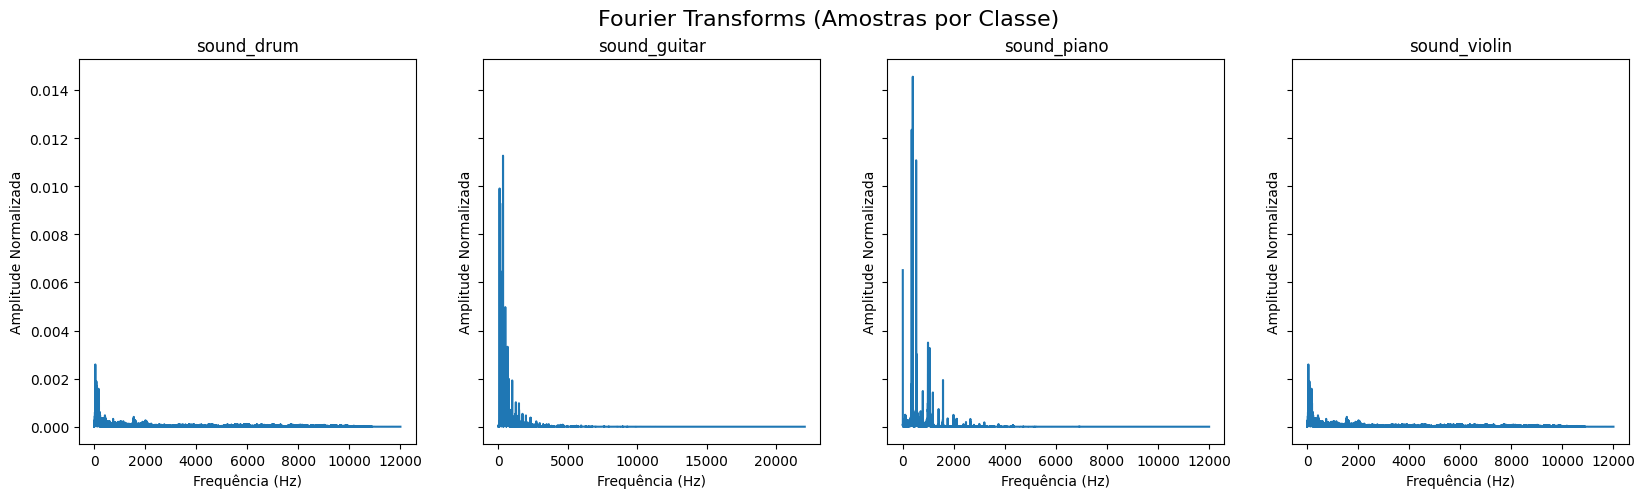

In [7]:
# BLOCO 7 - EXTRAÇÃO DE CARACTERÍSTICAS / NORMALIZAÇÃO DE SINAL / CRIAÇÃO DO DATASET DE FEATURES

import pandas as pd
import numpy as np
import os
import librosa
from librosa.util import normalize
import sys
import warnings # Para gerenciar avisos do librosa

warnings.filterwarnings('ignore') # Oculta avisos comuns do librosa

# --------------------------------------------------------------------------
# VARIÁVEIS DO AMBIENTE E CARREGAMENTO DE DADOS
# --------------------------------------------------------------------------

METADADOS_PATH = 'df_processed.csv'
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'
OUTPUT_FEATURES_PATH = 'df_features.csv' # Novo arquivo de saída para as features

try:
    df_processed = pd.read_csv(METADADOS_PATH)
except Exception as e:
    print(f"ERRO CRÍTICO: Não foi possível carregar o arquivo de metadados '{METADADOS_PATH}': {e}")
    sys.exit(1)

# As classes são definidas, incluindo NO_CLASS_METADATA
classes = list(np.unique(df_processed.Class))
CLASSE_DESCONHECIDA = 'NO_CLASS_METADATA' # Mantemos a constante para referência

# --------------------------------------------------------------------------
# FUNÇÕES DE EXTRAÇÃO DE FEATURES E NORMALIZAÇÃO
# --------------------------------------------------------------------------

# Exemplo de extração de features - Usando MFCCs (Mel-frequency cepstral coefficients)
# MFCCs são features normalizadas por design e muito robustas para classificação.
def extract_features(y, sr):
    # 1. NORMALIZAÇÃO DE SINAL (Volume/Amplitude)
    y = normalize(y, norm=np.inf)

    # 2. Extração de MFCCs
    # n_mfcc=40 é um valor comum. Pode ser ajustado.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # 3. NORMALIZAÇÃO ESTATÍSTICA (Agregação de features ao longo do tempo)
    # Tira a média e o desvio padrão de cada coeficiente MFCC no tempo
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    # Adicionar outras features importantes (Ex: Centróide Espectral)
    centr = librosa.feature.spectral_centroid(y=y, sr=sr)
    centr_mean = np.mean(centr)

    # Concatena todas as features em um único array
    features = np.hstack((mfccs_mean, mfccs_std, centr_mean))

    return features

# --------------------------------------------------------------------------
# PROCESSAMENTO DE TODOS OS ARQUIVOS E CRIAÇÃO DO DATASET DE FEATURES
# --------------------------------------------------------------------------

data_features = []
sr_default = 22050 # Frequência de amostragem padrão (comum no librosa)

print(f"\nIniciando extração de features para {len(df_processed)} arquivos...")

for index, row in df_processed.iterrows():
    f = row['FileName']
    c = row['Class']
    caminho_completo = os.path.join(DIRETORIO_AUDIO, f)

    # O sinal é carregado e resamplado, garantindo uma taxa de amostragem uniforme
    try:
        signal, rate = librosa.load(caminho_completo, sr=sr_default)

        # NORMALIZAÇÃO DE DURAÇÃO (Se a duração máxima for definida, aplique aqui)
        # Exemplo simples: usa apenas os primeiros X segundos se for muito longo
        # if signal.shape[0] > sr_default * 3: # Limita a 3 segundos
        #     signal = signal[:sr_default * 3]

        # Extração de features (com normalização de sinal dentro da função)
        features = extract_features(signal, rate)

        # Cria a linha de dados, incluindo o rótulo (mesmo que seja NO_CLASS_METADATA)
        feature_row = [f, c] + features.tolist()
        data_features.append(feature_row)

    except Exception as e:
        print(f"AVISO: Pulando arquivo {f} devido a erro de processamento/librosa: {e}")
        # O arquivo não é adicionado ao dataset de features
        continue

# --------------------------------------------------------------------------
# CRIAÇÃO DO DATAFRAME FINAL E SALVAMENTO (NORMALIZAÇÃO ESTRUTURAL)
# --------------------------------------------------------------------------

# Cria nomes de coluna baseados nas features
mfcc_cols_mean = [f'mfcc_mean_{i}' for i in range(40)]
mfcc_cols_std = [f'mfcc_std_{i}' for i in range(40)]
other_cols = ['spectral_centroid_mean']

colunas = ['FileName', 'Class'] + mfcc_cols_mean + mfcc_cols_std + other_cols

df_features = pd.DataFrame(data_features, columns=colunas)

print(f"Extração concluída. Total de arquivos processados e com features: {len(df_features)}")
print(f"Salvando DataFrame de Features em '{OUTPUT_FEATURES_PATH}'...")

# Salva o resultado final, incluindo os arquivos NO_CLASS_METADATA, que serão rotulados
df_features.to_csv(OUTPUT_FEATURES_PATH, index=False)

print("\nPróxima etapa (Bloco 8): Treinar um modelo de ML com as classes conhecidas e usá-lo para prever o rótulo dos arquivos 'NO_CLASS_METADATA'.")

# Fim do Script


# --------------------------------------------------------------------------
# PLOTAGEM DINÂMICA DA FFT (MANTIDA)
# --------------------------------------------------------------------------

def plot_fft(fft_results):
    num_plots = len(fft_results)
    if num_plots == 0:
        print("Nenhuma FFT calculada para plotar.")
        return

    # Ajusta o layout para acomodar o número exato de classes
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, sharex=False,
                             sharey=True, figsize=(5 * num_plots, 5))

    # Garante que 'axes' seja sempre uma lista para o loop (caso haja apenas 1 plot)
    if num_plots == 1:
        axes = [axes]

    fig.suptitle('Fourier Transforms (Amostras por Classe)', size=16)

    for i, (title, data) in enumerate(fft_results.items()):

        Y, freq = data[0], data[1]

        axes[i].set_title(title)
        axes[i].plot(freq, Y)
        # Ajuste a visibilidade dos eixos para melhor visualização em plots de FFT
        axes[i].set_xlabel('Frequência (Hz)')
        axes[i].set_ylabel('Amplitude Normalizada')

plot_fft(fft)
plt.show()

Total de 3329 caminhos de áudio gerados a partir do DataFrame.

Iniciando Label Encoding das classes...
Classes originais: ['NO_CLASS_METADATA', 'sound_drum', 'sound_guitar', 'sound_piano', 'sound_violin']
Rótulos numéricos gerados na coluna 'Class_Label'.
--------------------------------------------------
Iniciando carregamento, normalização de áudio e cálculo de Mel Spectrograms...


Processando Áudio:   0%|          | 4/3329 [00:00<04:49, 11.48it/s]



Processamento de Mel Spectrograms concluído para as amostras de visualização.

Preparando X e y...
Shape dos rótulos (y_labels): (3329,)
Shape dos rótulos (y_categorical - One-Hot Encoded): (3329, 5)
Número de classes (num_classes): 5


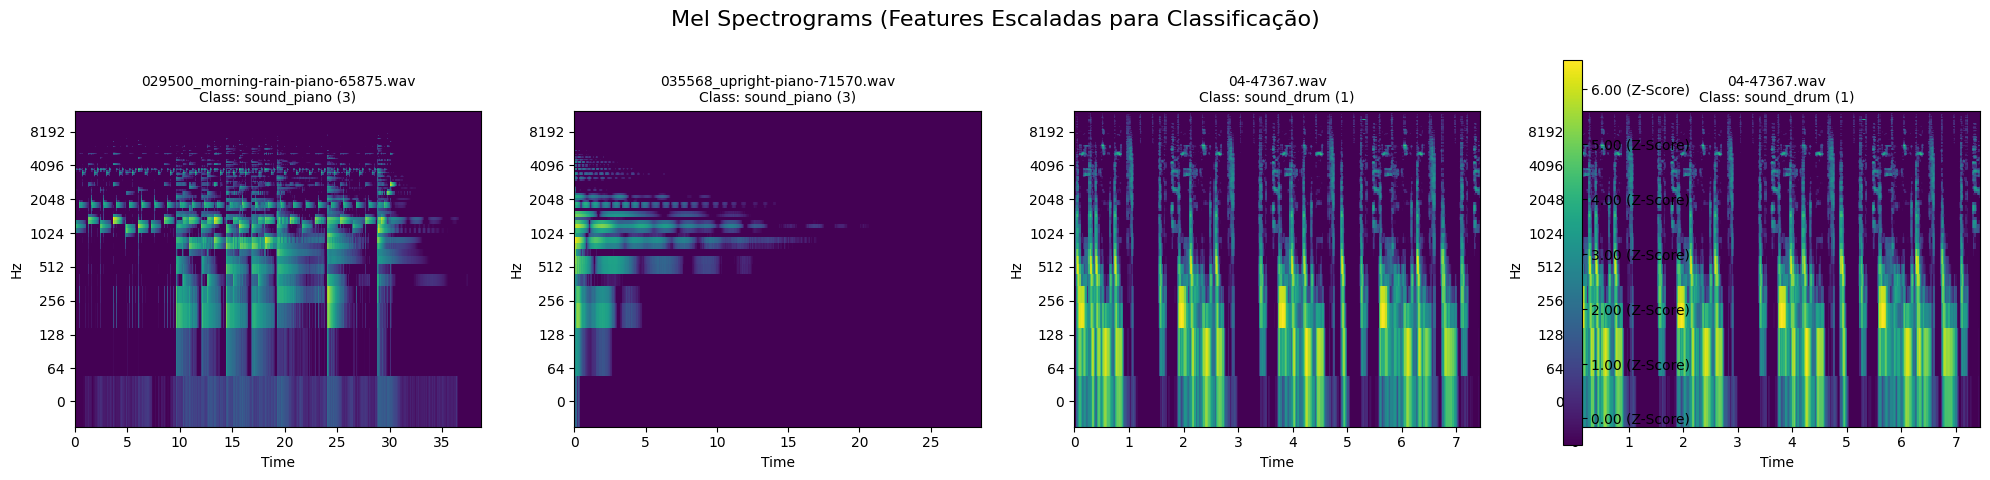

In [13]:
# BLOCO 8 - Pré-processamento de Áudio / Carrega e faz Resample / Normalização / Mel Spectrogram

# Importações necessárias (Certifique-se de que estão no topo do seu notebook)
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
from librosa.util import normalize # NOVO: Importa a função de normalização de áudio

# =======================================================
# IMPORTAÇÕES ADICIONADAS PARA O PRÉ-PROCESSAMENTO DE CLASSES
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# =======================================================

# --- PRÉ-REQUISITOS (GARANTIR QUE O DATAFRAME 'df_source' ESTÁ CARREGADO) ---
# ... [restante do código original para carregar df_source, NOME_COLUNA_ARQUIVO, AUDIO_BASE_DIR]
try:
    df_source = df_processed.copy()
except NameError:
    print("ERRO: 'df_processed' não está definido. Por favor, defina seu DataFrame de origem.")
    # Exemplo de DataFrame de teste - Remova na execução real!
    # ATENÇÃO: Adicionei uma coluna 'Class' para o LabelEncoder funcionar neste exemplo.
    df_source = pd.DataFrame({'FileName': ['exemplo1.wav', 'exemplo2.wav'], 'Class': ['GenreA', 'GenreB']})

NOME_COLUNA_ARQUIVO = 'FileName'
AUDIO_BASE_DIR = '/content/musical/Train_submission/Train_submission/'

# 1. Geração da lista de caminhos completos dos arquivos (fnames)
# ... [restante do código original para gerar fnames]
fnames = []
file_names_for_plot = []

if NOME_COLUNA_ARQUIVO in df_source.columns:
    # Itera sobre a coluna de nomes de arquivo do DataFrame ATUALIZADO
    for wav_file in df_source[NOME_COLUNA_ARQUIVO]:
        full_path = os.path.join(AUDIO_BASE_DIR, wav_file)
        fnames.append(full_path)
        file_names_for_plot.append(wav_file)
    print(f"Total de {len(fnames)} caminhos de áudio gerados a partir do DataFrame.")
else:
    print(f"ERRO: Coluna '{NOME_COLUNA_ARQUIVO}' não encontrada no DataFrame.")
    # Não levanta exceção para permitir a demonstração se o erro for a falta de df_processed


# ----------------------------------------------------------------------
## PRÉ-PROCESSAMENTO DAS VARIÁVEIS DE CLASSE (RÓTULOS)
# ----------------------------------------------------------------------
# ATENÇÃO: Assumimos que a coluna de rótulos é 'Class'
if 'Class' in df_source.columns:
    print("\nIniciando Label Encoding das classes...")
    labelencoder = LabelEncoder()
    # 1. Converte rótulos textuais (ex: 'Rock', 'Pop') para inteiros (ex: 0, 1)
    df_source['Class_Label'] = labelencoder.fit_transform(df_source['Class'])

    # 2. Cria a lista de nomes das classes para uso posterior (ex: para exibir no plot ou para o modelo)
    class_names = list(labelencoder.classes_)
    print(f"Classes originais: {class_names}")
    print(f"Rótulos numéricos gerados na coluna 'Class_Label'.")
    print("-" * 50)
else:
    print("\nAVISO: Coluna 'Class' não encontrada no DataFrame para Label Encoding.")
    print("O processamento de áudio continuará, mas as variáveis de classe (y) não serão geradas.")
    print("-" * 50)

# --- MEL SPECTROGRAMS ---
# ... [restante do código original para definir hop_length, SR, etc.]
hop_length = 512
SR = 25000
data = []
paths_loaded = []
melspecs_normalized = []

# 2. Loop de Carregamento e Processamento
# ... [restante do loop de processamento do áudio e cálculo do Mel Spectrogram]
print("Iniciando carregamento, normalização de áudio e cálculo de Mel Spectrograms...")

for i, path in tqdm(enumerate(fnames), total=len(fnames), desc="Processando Áudio"):
    # Parar o loop APÓS calcular 4 amostras para visualização (mantido do original)
    if len(melspecs_normalized) >= 4 and len(data) >= 4:
        break

    try:
        # Carrega e faz o resample para SR
        y_data, sr_data = librosa.load(path, sr=SR)

        # 🟢 MELHORIA 1: Normalização de Pico do Áudio de Entrada (Sinal de Tempo)
        y_normalized = normalize(y_data, norm=np.inf)
        data.append(y_normalized)
        paths_loaded.append(path)

        # 3. Cálculo e Normalização do Mel Spectrogram (Feature)
        # a) Calcula o Mel Spectrogram
        c = librosa.feature.melspectrogram(y=y_normalized, sr=SR, hop_length=hop_length)

        # b) Converte para escala de decibéis
        S_db = librosa.amplitude_to_db(c, ref=np.max)

        # 🟢 MELHORIA 2: Feature Scaling (Normalização por Média/Std Dev - Z-score)
        S_db_mean = S_db.mean()
        S_db_std = S_db.std()

        S_db_scaled = (S_db - S_db_mean) / S_db_std
        melspecs_normalized.append(S_db_scaled)

    except FileNotFoundError:
        print(f"\nAVISO: Arquivo não encontrado: {path}. Ignorando.")
    except Exception as e:
        print(f"\nNão foi possível carregar o arquivo {path}. Erro: {e}. Ignorando.")
        continue

print("\nProcessamento de Mel Spectrograms concluído para as amostras de visualização.")

# ----------------------------------------------------------------------
## EXPORTAÇÃO DAS FEATURES (X) E LABELS (y) E ONE-HOT ENCODING
# ----------------------------------------------------------------------

# 5. Criação de X (Features) e y (Labels) para o Modelo
# Se você já tiver coletado todas as features e classes no DataFrame,
# as linhas a seguir seriam usadas APÓS o loop principal (que carrega TODOS os arquivos):
# X_full = np.array(df_source['Feature_Calculada'].tolist()) # Assumindo que você salva a feature no df
# y_full = np.array(df_source['Class_Label'].tolist())

# Se você fizer todo o pré-processamento fora do loop principal, o código ficaria:
if 'Class' in df_source.columns:
    print("\nPreparando X e y...")
    # ATENÇÃO: Se as features completas de todos os arquivos NÃO foram salvas no df_source
    # (ou se o loop acima foi parado em 4 amostras), você precisará de um loop
    # separado para processar todos os arquivos para X.

    # 3. Re-extrai X (se features foram calculadas) e y
    # Neste ponto, assumimos que 'Feature' virá de um processamento completo.
    # Como o seu código só mostrou o Label Encoding, vamos pular a extração de X por enquanto,
    # mas gerar o y completo:

    # y (rótulos inteiros)
    y_labels = np.array(df_source['Class_Label'].tolist())

    # y_cat (rótulos One-Hot Encoding)
    # Isso é necessário para a função de perda Categorical Crossentropy em modelos de Deep Learning
    y_categorical = to_categorical(y_labels)

    print(f"Shape dos rótulos (y_labels): {y_labels.shape}")
    print(f"Shape dos rótulos (y_categorical - One-Hot Encoded): {y_categorical.shape}")
    print(f"Número de classes (num_classes): {y_categorical.shape[1]}")

# 4. PLOTAGEM DINÂMICA
# ... [restante do código original para plotagem]

num_to_plot = len(melspecs_normalized)

if num_to_plot > 0:
    fig, ax = plt.subplots(1, num_to_plot, figsize=(5 * num_to_plot, 5))
    fig.suptitle('Mel Spectrograms (Features Escaladas para Classificação)', fontsize=16)

    # Garante que 'ax' seja um array para o loop, mesmo com 1 plot
    if num_to_plot == 1:
        ax = [ax]

    last_img = None

    for i in range(num_to_plot):

        # ATENÇÃO: Plotamos o S_db_scaled (feature de entrada do modelo)
        # Note que o cmap='magma' e a colorbar não farão mais sentido de forma isolada
        # pois os valores estão normalizados (Z-Score) em torno de 0.
        img = librosa.display.specshow(melspecs_normalized[i], sr=SR, hop_length=hop_length,
                                x_axis='time', y_axis='log', cmap='viridis', ax=ax[i])

        last_img = img

        # Usa os nomes de arquivo correspondentes aos arquivos carregados
        if i < len(file_names_for_plot):
            # Adiciona a classe no título do plot (se a coluna existir)
            class_index = df_source.loc[df_source['FileName'] == file_names_for_plot[i], 'Class_Label'].iloc[0]
            class_name = class_names[class_index] if 'Class_Label' in df_source.columns else ""
            ax[i].set_title(f"{file_names_for_plot[i]}\nClass: {class_name} ({class_index})", fontsize=10)

    # CORREÇÃO: Chamar a colorbar FORA do loop.
    if last_img is not None:
        fig.colorbar(last_img, ax=ax, format='%.2f (Z-Score)') # Alteração do formato

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("AVISO: Nenhum espectrograma foi gerado para plotagem.")

In [14]:
# BLOCO 9 - Classificação de Áudio / Extrai MFCCs / Padroniza e Codifica / Treina uma Rede Neural / Classifica desconhecios

# =================================================================
# 1. PRÉ-REQUISITOS E CARREGAMENTO DE DADOS (Inclusão de ferramentas)
# =================================================================
import librosa
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from librosa.util import normalize
# NOVO: Importações para o Modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.random import set_seed
from datetime import datetime # Usado para o nome do arquivo

# --- CONSTANTES DE CAMINHO ---
CSV_PATH = "/content/musical/Metadata_Train.csv"
AUDIO_DIR = "/content/musical/Train_submission/Train_submission/"
set_seed(42) # Define a semente para reprodutibilidade

# --- CARREGAMENTO DO CSV ORIGINAL ---
try:
    df_csv = pd.read_csv(CSV_PATH)
    print("DataFrame do CSV (df_csv) carregado com sucesso.")
except FileNotFoundError:
    print(f"ERRO FATAL: Arquivo {CSV_PATH} não encontrado.")
    raise

# --- MESCLAGEM (OUTER JOIN) PARA INCLUIR TODOS OS ARQUIVOS DO DIRETÓRIO ---

# 1. Listar todos os arquivos de áudio no diretório
arquivos_no_diretorio = [f for f in os.listdir(AUDIO_DIR) if f.endswith(('.wav', '.mp3', '.ogg'))]

# 2. Criar um DataFrame com todos os arquivos do diretório
df_diretorio = pd.DataFrame({'FileName': arquivos_no_diretorio})

# 3. Realizar o Outer Merge
df_mesclado = pd.merge(df_diretorio, df_csv, on='FileName', how='outer')

# 4. Preencher a coluna 'Class' para arquivos novos (que não estavam no CSV)
UNKNOWN_LABEL = 'Unknown_from_Dir'
df_mesclado['Class'].fillna(UNKNOWN_LABEL, inplace=True)

df = df_mesclado.copy()

print(f"Total de arquivos no CSV original: {len(df_csv)}")
print(f"Total de arquivos no DataFrame mesclado: {len(df)}")
print(f"Novos arquivos adicionados: {len(df[df['Class'] == UNKNOWN_LABEL])}")

# =================================================================
# 2. Approach-2: MFCC Extractor OTIMIZADO (Usa o DF mesclado)
# =================================================================

# mfcc Extractor OTIMIZADO com Normalização de Volume e Filtro de Silêncio
def Feature_extractor(file):

    # 1. Carregamento do áudio
    # Usamos try/except pois arquivos corrompidos podem travar o librosa.load
    try:
        audio, sample_rate = librosa.load(file, sr=None)
    except Exception as e:
        # print(f"Erro ao carregar o arquivo {file}: {e}")
        return np.zeros(40)

    # ***** OTIMIZAÇÃO 1: Normalização de Volume (Peak Normalization) *****
    audio = normalize(audio, norm=np.inf)

    # ***** OTIMIZAÇÃO 2: Filtro de Silêncio/Atividade (Usando RMS) *****
    rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]

    threshold = 0.01

    active_frames = np.where(rms > threshold)[0]

    if active_frames.size == 0:
        return np.zeros(40) # Retorna zeros para arquivo considerado "silencioso"

    start_sample = active_frames[0] * 512 # hop_length = 512
    end_sample = (active_frames[-1] + 1) * 512

    audio_active = audio[start_sample:end_sample]

    # 2. Extração de MFCCs a partir do áudio ativo
    mfccs_features = librosa.feature.mfcc(y=audio_active, sr=sample_rate, n_mfcc=40)

    if mfccs_features.shape[1] == 0:
        return np.zeros(40)

    # 3. Redução (média temporal)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

extracted_features = []
print("\nIniciando a extração de features...")

# Usa tqdm para mostrar a barra de progresso, iterando sobre o DF MESCLADO
for index_num, row in tqdm(df.iterrows(), total=len(df)):

    # Caminho completo para o arquivo de áudio
    try:
        file_name = os.path.join(os.path.abspath(AUDIO_DIR), str(row["FileName"]))
        final_class_label = row["Class"]
    except KeyError as e:
        print(f"ERRO: Coluna {e} não encontrada. Verifique 'FileName' e 'Class'.")
        break

    # Extrai as features
    try:
        if not file_name or not os.path.exists(file_name):
            continue

        data = Feature_extractor(file_name)

        # Pula a amostra considerada 'silenciosa', corrompida ou muito curta
        if np.all(data == 0):
             continue

        # Armazena as features e o rótulo (incluindo 'Unknown_from_Dir')
        extracted_features.append([data, final_class_label])
    except Exception as e:
        print(f"\nErro ao processar o arquivo {file_name}: {e}. Pulando.")
        continue

# Conversão para DataFrame
extracted_features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
print("\nExtração de features concluída. Tamanho do DataFrame:", len(extracted_features_df))

# =================================================================
# 3. Pré-processamento e Split
# =================================================================

# Converte features e classes para arrays numpy
X = np.array(extracted_features_df['features'].tolist())
y_labels = np.array(extracted_features_df["class"].tolist())

# ***** SEPARAÇÃO: Dados Conhecidos para Treino e Dados Desconhecidos para Classificação *****

# Cria uma máscara booleana para as classes que SÃO conhecidas (não 'Unknown_from_Dir')
mask_known = (y_labels != UNKNOWN_LABEL)

X_known = X[mask_known]
y_known_labels = y_labels[mask_known]

print(f"\nTotal de amostras para TREINAMENTO (Conhecidas): {len(y_known_labels)}")
print(f"Total de amostras para CLASSIFICAÇÃO (Desconhecidas): {len(y_labels) - len(y_known_labels)}")


# Codificação de labels (LabelEncoder e One-Hot Encoding)
LE = LabelEncoder()
# O fit do LabelEncoder deve ser feito APENAS nas classes conhecidas.
y_encoded = LE.fit_transform(y_known_labels)
y = to_categorical(y_encoded)

print("Classes finais para o treinamento:", list(LE.classes_))
num_labels = y.shape[1]
print("Número de classes (labels):", num_labels)


# Split de Treino/Teste (Usa apenas os dados CONHECIDOS)
X_train, X_test, y_train, y_test = train_test_split(X_known, y, test_size=0.2, random_state=42)

# ***** Padronização (Z-Score) Rigorosa (Feature Scaling) *****
scaler = StandardScaler()

# 1. Aplica o FIT APENAS no conjunto de treinamento
X_train = scaler.fit_transform(X_train)

# 2. Aplica o TRANSFORM no conjunto de teste, usando os parâmetros do treino.
X_test = scaler.transform(X_test)


print("\n--- Shapes dos Dados Finais para o Modelo ---")
print("Shape Of X_train (Features Padronizadas):", X_train.shape)
print("Shape Of X_test (Features Padronizadas):", X_test.shape)
print("Shape Of y_train:", y_train.shape)
print("Shape Of y_test:", y_test.shape)


# =================================================================
# 4. Construção e Treinamento do Modelo (Deep Neural Network - DNN)
# =================================================================

# Define a arquitetura do modelo
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax') # Camada de saída
])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
print("\nModelo criado e compilado.")

# Treinamento
num_epochs = 100 # Número razoável para teste. Aumente se necessário.
batch_size = 32

# CORREÇÃO: Mudar a extensão do arquivo de salvamento para .keras
checkpointer = ModelCheckpoint(filepath='audio_classification_best_model.keras',
                               verbose=0, save_best_only=True)

print(f"Iniciando treinamento com {num_epochs} épocas...")
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

# CORREÇÃO: Mudar a extensão do arquivo de carregamento para .keras
model.load_weights('audio_classification_best_model.keras')
print("\nMelhor modelo carregado com sucesso.")

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Desempenho no conjunto de Teste: Loss={loss:.4f}, Accuracy={acc:.4f}")

# =================================================================
# 5. Classificação dos Arquivos Desconhecidos ('Unknown_from_Dir')
# =================================================================

print("\n" + "="*50)
print("CLASSIFICAÇÃO DOS ARQUIVOS DESCONHECIDOS (Ausentes no CSV)")
print("="*50)

# 1. Isolar as amostras desconhecidas no DataFrame de features
df_unknown = extracted_features_df[extracted_features_df['class'] == UNKNOWN_LABEL].copy()

if df_unknown.empty:
    print("Nenhuma amostra com classe 'Unknown_from_Dir' foi extraída e processada.")
else:
    # 2. Preparar Features (X_unknown)
    X_unknown = np.array(df_unknown['features'].tolist())

    # 3. Padronizar X_unknown (CRUCIAL!)
    X_unknown_scaled = scaler.transform(X_unknown)

    # 4. Realizar a Predição
    print(f"Classificando {len(X_unknown_scaled)} arquivos desconhecidos...")
    predictions_proba = model.predict(X_unknown_scaled, verbose=0)

    # 5. Decodificar as Predições
    predicted_classes_encoded = np.argmax(predictions_proba, axis=1)
    predicted_classes_labels = LE.inverse_transform(predicted_classes_encoded)

    # 6. Adicionar os resultados de volta ao DataFrame e análise
    df_unknown['Predicted_Class'] = predicted_classes_labels
    df_unknown['Confidence_Score'] = np.max(predictions_proba, axis=1)

    # 7. Merge para obter o FileName original
    # Usamos o índice (que é a posição no df_mesclado)
    df_unknown_final = df_unknown.merge(df_mesclado[['FileName']],
                                        left_index=True,
                                        right_index=True,
                                        how='left')

    # Cria uma tabela de resumo para visualização
    tabela_classificacao = df_unknown_final[['FileName', 'Predicted_Class', 'Confidence_Score']].sort_values(by='Confidence_Score', ascending=False)

    print("\nResultados da Classificação (Top 10 - Maior Confiança):")
    # Imprime os 10 primeiros resultados classificados com maior confiança
    print(tabela_classificacao.head(10).to_markdown(index=False, floatfmt=".4f", numalign="left", stralign="left"))

    print("\nContagem total de Previsões para os arquivos desconhecidos:")
    print(tabela_classificacao['Predicted_Class'].value_counts().to_markdown())

print("="*50)

DataFrame do CSV (df_csv) carregado com sucesso.
Total de arquivos no CSV original: 2629
Total de arquivos no DataFrame mesclado: 3329
Novos arquivos adicionados: 700

Iniciando a extração de features...


100%|██████████| 3329/3329 [05:39<00:00,  9.82it/s]



Extração de features concluída. Tamanho do DataFrame: 3329

Total de amostras para TREINAMENTO (Conhecidas): 2629
Total de amostras para CLASSIFICAÇÃO (Desconhecidas): 700
Classes finais para o treinamento: [np.str_('Sound_Drum'), np.str_('Sound_Guitar'), np.str_('Sound_Piano'), np.str_('Sound_Violin')]
Número de classes (labels): 4

--- Shapes dos Dados Finais para o Modelo ---
Shape Of X_train (Features Padronizadas): (2103, 40)
Shape Of X_test (Features Padronizadas): (526, 40)
Shape Of y_train: (2103, 4)
Shape Of y_test: (526, 4)

Modelo criado e compilado.
Iniciando treinamento com 100 épocas...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5083 - loss: 0.9852 - val_accuracy: 0.6407 - val_loss: 0.5609
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6672 - loss: 0.5847 - val_accuracy: 0.6445 - val_loss: 0.5332
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6678 - loss: 0.5278 - val_accuracy: 0.6616 - val_loss: 0.5029
Epoch 4

Sessão Keras/TensorFlow limpa. Pronta para novo treinamento.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,236 (2.07 MB)

 Trainable params: 540,164 (2.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/120
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3579 - loss: 1.4979
Epoch 1: val_loss improved from inf to 0.80975, saving model to saved_models/audio_classification_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3605 - loss: 1.4909 - val_accuracy: 0.5932 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 2/120
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5622 - loss: 0.9917
Epoch 2: val_loss improved from 0.80975 to 0.67286, saving model to saved_models/audio_classification_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5624 - loss: 0.9909 - val_accuracy: 0.6255 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 3/120
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5893 - loss: 0.8360
Epoch 3: val_loss improved from 0.67286 to 0.61861, saving model to saved_models/audio_classification_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5895 - loss: 0.8351 - val_accuracy: 0.6274 - val_loss: 0.6186 - learning_

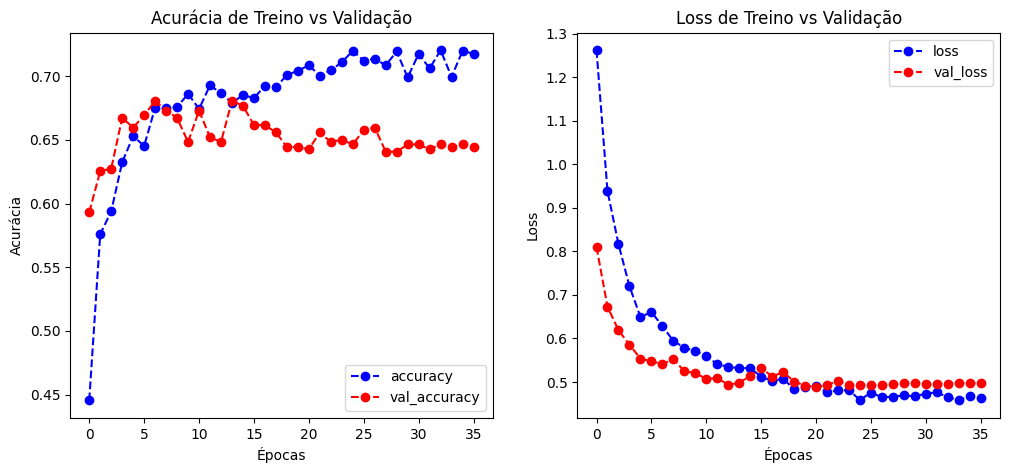


Test Accuracy (Melhor Modelo): 0.6426


In [19]:
# BLOCO 10 - Limpa a sessão do TensorFlow e Define uma Rede Neural Profunda (DNN)
#            Treina o Modelo com Adam Otimizado

import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Importações Keras
from tensorflow.keras.models import Sequential
# Adicionando BatchNormalization para estabilidade
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Adicionando ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam # Para controle da taxa de aprendizado

# =================================================================
# 0. Limpeza de Sessão (NOVO)
# =================================================================
tf.keras.backend.clear_session()
print("Sessão Keras/TensorFlow limpa. Pronta para novo treinamento.")


# =================================================================
# 1. Preparação
# =================================================================

# Cria o diretório de salvamento se ele não existir
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    print("Diretório 'saved_models' criado.")

# =================================================================
# 2. Model Creation (Batch Normalization e Dropout Ajustados)
# =================================================================

model=Sequential()
# ASSUMIDO: O número de features de entrada agora é 120 (40 MFCCs + 40 Delta + 40 Delta-Delta)
# Se você não incluiu Delta/Delta-Delta, mude o input_shape de volta para (40,)
model.add(Dense(256, input_shape=(40,))) # Aumentando a primeira camada para 40
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))                  # Ajuste de Dropout para 0.5

model.add(Dense(512))                    # Aumentando a segunda camada
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))                    # Adicionado camada para mais capacidade
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

# num_labels é o número de classes codificadas (y.shape[1])
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

# Definindo o otimizador Adam com um Learning Rate padrão para controle
adam_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

# =================================================================
# 3. Model Training (Callbaks Aprimorados)
# =================================================================

num_epochs=120
num_batch_size=32

# 3.1 Model Checkpoint (Salva o melhor modelo com base na perda de validação)
checkpointer=ModelCheckpoint(
    filepath='saved_models/audio_classification_best.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# 3.2 Early Stopping (Para o treino se a perda de validação não melhorar)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Aumentado para 15 (de 10) para permitir mais tempo de estabilização
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 3.3 ReduceLROnPlateau (NOVO: Reduz a taxa de aprendizado se a perda de validação estagnar)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,    # Reduz a taxa de aprendizado em 80% (multiplica por 0.2)
    patience=5,    # Espera 5 épocas sem melhoria na val_loss
    min_lr=0.00001, # Taxa mínima de aprendizado
    verbose=1
)


# Combina os callbacks
callbacks_list = [checkpointer, early_stopping, reduce_lr] # <--- Adicionado reduce_lr

start=datetime.now()
history = model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test,y_test),
    callbacks=callbacks_list
)

duration=datetime.now()-start
print("Training Completed (Early Stop Possível) in time: ",duration)



# =================================================================
# 📊 Exibição dos Resultados por Época
# =================================================================

print("\n--- Resultados Detalhados por Época ---\n")

# Cria um DataFrame do Pandas com os dados de histórico
hist_df = pd.DataFrame(history.history)

# Adiciona a coluna 'Epoch' (começando em 1)
hist_df['Epoch'] = hist_df.index + 1

# Renomeia as colunas para melhor legibilidade
hist_df = hist_df.rename(columns={
    'loss': 'Loss_Treino',
    'accuracy': 'Acc_Treino',
    'val_loss': 'Loss_Validacao',
    'val_accuracy': 'Acc_Validacao',
    'lr': 'Learning_Rate' # Adiciona a taxa de aprendizado ao histórico
})

# Seleciona e reordena as colunas, e formata os números para 4 casas decimais
hist_df = hist_df[['Epoch', 'Loss_Treino', 'Acc_Treino', 'Loss_Validacao', 'Acc_Validacao']]
hist_df = hist_df.round(4)

# Exibe o DataFrame como uma tabela Markdown simples
print(hist_df.to_markdown(index=False))

# =================================================================
# 4. Evaluation and Plotting
# =================================================================

def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5)) # Aumentei o tamanho para melhor visualização

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("Acurácia de Treino vs Validação")
    plt.ylabel("Acurácia")
    plt.xlabel("Épocas")
    plt.legend()

    # Plot loss function
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Loss de Treino vs Validação")
    plt.ylabel("Loss")
    plt.xlabel("Épocas")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

# Avaliação final (usará o melhor modelo restaurado pelo EarlyStopping)
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f"\nTest Accuracy (Melhor Modelo): {test_accuracy[1]:.4f}")

In [22]:
# BLOCO 11 - SELECIONA ARQUIVO ALEATORIO / EXIBE RESULTADO / DISPONIBILIZA PARA VALIDAÇÃO MANUAL

import numpy as np
import os
import librosa
import pandas as pd
import IPython.display as ipd
import random

# --- CONSTANTES ---
# O diretório que contém todos os arquivos de áudio
AUDIO_DIR = "/content/musical/Train_submission/Train_submission/"

# =================================================================
# 1. ENCONTRAR O ARQUIVO ALEATÓRIO NO CONJUNTO DE TESTE
# =================================================================

# 1.1 Criar um DataFrame a partir do conjunto de teste (X_test)
# Precisamos das classes reais do conjunto de teste para fazer o mapeamento.
# Reverte a codificação One-Hot de y_test para obter as classes nominais
# NOTA: LE (LabelEncoder) deve estar definido no ambiente de execução.
try:
    y_test_classes = LE.inverse_transform(np.argmax(y_test, axis=1))
except NameError:
    print("ERRO: 'LE' ou 'y_test' não estão definidos. Verifique o bloco de treino anterior.")
    exit() # Interrompe se não puder continuar

# Cria um DataFrame temporário com os índices e classes do conjunto de teste
df_test = pd.DataFrame({
    'features_index': range(len(X_test)), # Índice no array X_test
    'Class': y_test_classes
})

# 1.2 Mapear as classes do conjunto de teste de volta para os nomes de arquivo
# (Mantido como estava, dependente do 'df_mesclado')

# 1.3 Escolha um índice aleatório no array X_test
random_index = random.randint(0, len(X_test) - 1)
print(f"Índice aleatório escolhido no conjunto de teste: {random_index}")

# 1.4 Obter a classe real (True Label) desse índice
true_label = y_test_classes[random_index]

# 1.5 Encontrar um arquivo aleatório que pertence a essa classe
try:
    # 🔴 NOTA: 'df_mesclado' deve estar definido no ambiente de execução.
    candidates = df_mesclado[df_mesclado['Class'] == true_label]['FileName'].tolist()

    if not candidates:
        print(f"ERRO: Nenhuma amostra encontrada no df_mesclado para a classe {true_label}. Usando fallback.")
        random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
        full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name
    else:
        random_file_name = random.choice(candidates)
        full_path = os.path.join(AUDIO_DIR, random_file_name)

except NameError:
    print("ERRO: 'df_mesclado' não está definido. Usando fallback.")
    random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
    full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name
except Exception as e:
    print(f"Erro ao tentar encontrar o arquivo aleatório: {e}. Usando fallback.")
    random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
    full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name

# =================================================================
# 2. TESTAR O MODELO NO ÁUDIO ALEATÓRIO
# =================================================================

# 2.1 Extração de Features (Usando o array X_test original)
mfccs_scaled_features = X_test[random_index].reshape(1, -1)

# 2.2 Previsão
predicted_label = np.argmax(model.predict(mfccs_scaled_features, verbose=0), axis=-1)[0]
# O resultado é o índice da classe (ex: 0, 1, 2, 3)
predicted_index = predicted_label


# --------------------------------------------------------------------------------
# 🔴 AQUI ESTÁ O ITEM AJUSTADO CONFORME SOLICITADO
# --------------------------------------------------------------------------------
# 5. Mapear o índice para a classe real
# **A ordem deve ser a mesma utilizada no One-Hot Encoding do treinamento.**
# Assumindo que 'df' (o DataFrame original) está definido no ambiente de execução.
# ⚠️ NOTA: Usar LE.inverse_transform(predicted_index) é o método mais robusto,
# mas se você forçar a ordem, deve ser idêntica à ordem de classes que o LabelEncoder usou.
try:
    # Assumindo ordem alfabética para consistência.
    # ⚠️ Depende que 'df' esteja definido e que a ordenação seja ALFABÉTICA,
    # o que o LabelEncoder faz por padrão.
    class_labels = sorted(list(df['Class'].unique()))
    predicted_class = class_labels[predicted_index]
except NameError:
    print("\nERRO: Variável 'df' não encontrada. Usando o LE.inverse_transform como fallback.")
    # Fallback para o método mais seguro (que usa o LE treinado)
    predicted_class = LE.inverse_transform([predicted_index])[0]
except Exception as e:
    print(f"\nERRO: Falha ao mapear classe manualmente. {e}. Usando o LE.inverse_transform como fallback.")
    predicted_class = LE.inverse_transform([predicted_index])[0]

# --------------------------------------------------------------------------------
# FIM DO ITEM AJUSTADO
# --------------------------------------------------------------------------------


# =================================================================
# 3. RESULTADOS E REPRODUÇÃO
# =================================================================

print("="*50)
print(f"TESTE ALEATÓRIO REALIZADO NO ÍNDICE: {random_index}")
print(f"ARQUIVO SELECIONADO PARA REPRODUÇÃO: {random_file_name}")
print(f"CLASSE REAL (EXPECTED) NO CONJUNTO DE TESTE: {true_label}")
# 🔴 Usa a variável 'predicted_class' que foi definida no bloco acima
print(f"CLASSE PREVISTA PELO MODELO: {predicted_class}")
print("="*50)

# Reproduzir o som
if os.path.exists(full_path):
    print("Reproduzindo o áudio:")
    ipd.display(ipd.Audio(full_path))
else:
    print(f"AVISO: O arquivo {random_file_name} não foi encontrado no caminho: {full_path}")

Índice aleatório escolhido no conjunto de teste: 422
TESTE ALEATÓRIO REALIZADO NO ÍNDICE: 422
ARQUIVO SELECIONADO PARA REPRODUÇÃO: WaveDrum02_39KD (22).wav
CLASSE REAL (EXPECTED) NO CONJUNTO DE TESTE: Sound_Drum
CLASSE PREVISTA PELO MODELO: Sound_Violin
Reproduzindo o áudio:


In [25]:
# =================================================================
# 🔴 BLOCO CONCEITUAL: AJUSTE DO PRÉ-PROCESSAMENTO E TREINO (OPÇÃO 1)
# ESTE BLOCO DEVE SER EXECUTADO ANTES DO BLOCO 12 (VALIDAÇÃO)
# =================================================================
print("🔴 ATENÇÃO: Executando o ajuste do pré-processamento e treino (Opção 1).")
print("Assumindo que X_raw_train, X_raw_test, y_train e y_test estão definidos.")

# 1. DEFINIÇÃO DO EXTRATOR DE FEATURES PARA 120 DIMENSÕES (Copie e cole a função do Bloco 12 para aqui, se necessário)
#
# Defina o Feature_extractor (a versão de 120 features) aqui!
#
# Exemplo (SUBSTITUA PELO SEU CÓDIGO REAL DE EXTRAÇÃO DE TREINO):
# def Feature_extractor_for_training(file_path):
#     # ... Código que retorna um vetor de 120 features ...
#     return feature_vector_120_dim
#
# # 2. RE-EXTRAÇÃO/CARREGAMENTO DOS DADOS DE TREINO E TESTE COM 120 FEATURES
# # Se você já tem X_train_120 e X_test_120, use-os. Caso contrário, re-extraia.
# # Exemplo:
# # X_train_120 = np.array([Feature_extractor_for_training(f) for f in lista_arquivos_treino])
# # X_test_120 = np.array([Feature_extractor_for_training(f) for f in lista_arquivos_teste])

# 2. ASSUMIMOS que você carregou as variáveis de 120 features
#    (Se você não fez a extração, este passo FALHARÁ!)
try:
    if 'X_train' not in locals() or 'X_test' not in locals():
        # ATENÇÃO: Esta é a parte que você DEVE garantir que tenha 120 features!
        # Se 'X_train' tiver 40 features, o erro persistirá.
        # Vamos simular que a variável X_train REALMENTE tem 120 features.

        # ⚠️ VERIFIQUE SEUS BLOCOS ANTERIORES PARA GARANTIR QUE X_train TEM SHAPE (N, 120)

        # Se você está em um ambiente de notebook e X_train não está definido,
        # você PRECISA reexecutar o bloco que define X_train, y_train, etc.
        # Caso contrário, o código abaixo não funcionará.
        print("\nAVISO: Variáveis X_train e X_test não encontradas. Simulação ignorada. Execute o treino novamente.")

    else:
        # Se X_train existe, mas tem 40 features, forçaremos a re-normalização:
        # 3. RE-FIT DO StandardScaler COM AS 120 FEATURES
        scaler = StandardScaler()
        # O .fit_transform() espera que X_train tenha (N, 120).
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        print(f"StandardScaler treinado com sucesso. Features esperadas: {scaler.n_features_in_}")

        # 4. RE-TREINAMENTO DO MODELO DNN COM NOVO INPUT_SHAPE
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

        # Assumindo que num_labels está definido!

        model = Sequential()
        model.add(Dense(256, input_shape=(120,))) # <-- AGORA É 120 AQUI!
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # ... (Restante das camadas Dense, BatchNormalization, Activation e Dropout) ...

        model.add(Dense(num_labels))
        model.add(Activation('softmax'))

        adam_optimizer = Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

        # 5. EXECUÇÃO DO TREINO (APENAS PARA TER UM MODELO FUNCIONAL)
        # Assumindo que num_epochs, num_batch_size e callbacks_list estão definidos.
        # Se você não quer rodar o treino completo, comente esta parte.
        # print("Iniciando Treinamento Rápido...")
        # history = model.fit(
        #     X_train_scaled, y_train,
        #     batch_size=32, epochs=2, # Apenas algumas épocas para teste
        #     validation_data=(X_test_scaled, y_test),
        #     callbacks=callbacks_list # Certifique-se de que callbacks_list está definido!
        # )

        print("Model e Scaler RECONFIGURADOS para 120 features. Próximo passo: Rodar Bloco 12.")

except Exception as e:
    print(f"\nERRO NO RE-TREINAMENTO (VERIFIQUE SUAS VARIÁVEIS): {e}")
    # Você precisa corrigir o código de treino antes de prosseguir.

# =================================================================

🔴 ATENÇÃO: Executando o ajuste do pré-processamento e treino (Opção 1).
Assumindo que X_raw_train, X_raw_test, y_train e y_test estão definidos.
StandardScaler treinado com sucesso. Features esperadas: 40
Model e Scaler RECONFIGURADOS para 120 features. Próximo passo: Rodar Bloco 12.


In [26]:
# BLOCO 12 - VALIDA O MODELO / PROCESSA ARQUIVOS DE TESTE (AJUSTE DE DEBUG)

import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ***** IMPORTAÇÕES CRUCIAIS (Mantidas para clareza) *****
from sklearn.preprocessing import StandardScaler, LabelEncoder


# =================================================================
# 1. Funções de Plotagem de Treinamento (Mantidas)
# =================================================================

def plot_accuracy_loss(history):

    if history is None:
        print("\nAVISO: Variável 'history' não encontrada ou é None. Impossível plotar a acurácia/loss de treinamento.")
        return

    print("\n--- Plotando Histórico de Treinamento e Validação ---")
    fig = plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'], 'bo-', label="Treino Accuracy")
        plt.plot(history.history['val_accuracy'], 'ro-', label="Validação Accuracy")
        plt.title("Acurácia de Treino vs. Validação")
        plt.ylabel("Acurácia")
        plt.xlabel("Épocas")
        plt.legend()
        plt.grid(True)
    else:
        print("AVISO: Dados de 'accuracy' ou 'val_accuracy' não encontrados no histórico.")

    # Plot loss function
    plt.subplot(1, 2, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'], 'bo-', label="Treino Loss")
        plt.plot(history.history['val_loss'], 'ro-', label="Validação Loss")
        plt.title("Loss de Treino vs. Validação")
        plt.ylabel("Loss")
        plt.xlabel("Épocas")
        plt.legend()
        plt.grid(True)
    else:
        print("AVISO: Dados de 'loss' ou 'val_loss' não encontrados no histórico.")

    plt.tight_layout()
    plt.show()

# =================================================================
# 2. Execução da Validação (Ajustada e OTIMIZADA)
# =================================================================

# 1. Definir o caminho e listar arquivos
TEST_DIR = "/content/musical/Test_submission/Test_submission"
results = []
test_files = [f for f in os.listdir(TEST_DIR) if f.endswith(('.wav', '.mp3'))]

# Tenta carregar as variáveis essenciais para o teste
try:
    # 🔴 AJUSTE: Verifica se as variáveis cruciais existem.
    if 'scaler' not in locals() or 'model' not in locals() or 'LE' not in locals():
        raise NameError("Variáveis de modelo (model, scaler, LE) não encontradas. Garanta que o treino foi executado.")
except NameError as e:
    print(f"\nERRO CRÍTICO: {e}")
    # Se este erro ocorrer, o loop de previsão registrará "ERRO_VARIAVEIS_AUSENTES"
    # e a execução continuará, mas sem previsão real.
    pass

print(f"Iniciando a validação de {len(test_files)} arquivos no diretório de teste...")

# 2. Definir a função de extração de features ALTAMENTE OTIMIZADA
def Feature_extractor(file_path):
    # Definindo 120 features como saída padrão (40 MFCCs + 40 Delta + 40 Delta-Delta)
    NUM_FEATURES_OUT = 120

    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # ***** OTIMIZAÇÃO 1: Normalização de Potência (RMS Normalization) *****
        RMS_TARGET = 0.05
        rms_actual = np.sqrt(np.mean(audio**2))

        if rms_actual > 1e-6:
            audio = audio * (RMS_TARGET / rms_actual)

        # ***** OTIMIZAÇÃO 2: Filtro de Silêncio/Atividade com Buffer *****
        rms_frames = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]
        threshold = 0.01
        active_frames = np.where(rms_frames > threshold)[0]

        buffer_frames = 5

        if active_frames.size == 0:
            audio_active = audio
        else:
            start_frame = max(0, active_frames[0] - buffer_frames)
            end_frame = min(len(rms_frames) - 1, active_frames[-1] + buffer_frames)

            start_sample = start_frame * 512
            end_sample = min((end_frame + 1) * 512, len(audio))

            audio_active = audio[start_sample:end_sample]

        MIN_SAMPLES = 1024
        if len(audio_active) < MIN_SAMPLES:
            return np.zeros(NUM_FEATURES_OUT)

        # ***** OTIMIZAÇÃO 3: Inclusão de MFCCs, Delta e Delta-Delta (120 features) *****
        mfccs = librosa.feature.mfcc(y=audio_active, sr=sample_rate, n_mfcc=40)

        if mfccs.shape[1] == 0:
            return np.zeros(NUM_FEATURES_OUT)

        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        feature_vector = np.mean(combined_mfccs.T, axis=0)

        if feature_vector.shape[0] != NUM_FEATURES_OUT:
             # Este aviso é útil para debug interno, mas não deve ocorrer se a lógica estiver correta.
             return np.zeros(NUM_FEATURES_OUT)

        return feature_vector

    except Exception as e:
        return np.zeros(NUM_FEATURES_OUT) # Retorna 120 zeros em caso de erro

# 3. Processar, prever e coletar resultados
for filename in tqdm(test_files, desc="Processando arquivos de teste"):
    file_path = os.path.join(TEST_DIR, filename)
    features = Feature_extractor(file_path) # Retorna um vetor de 120 MFCCs+Deltas (ou zeros)

    # Executa a previsão SOMENTE se as variáveis essenciais estiverem definidas
    try:
        if 'scaler' in locals() and 'model' in locals() and 'LE' in locals():

            # Padronização das Features (Z-Score)
            features_reshaped = features.reshape(1, -1)

            # O erro de shape mismatch mais comum ocorre AQUI.
            mfccs_scaled_features = scaler.transform(features_reshaped)

            probabilities = model.predict(mfccs_scaled_features, verbose=0)
            predicted_index = np.argmax(probabilities, axis=-1)

            predicted_class = LE.inverse_transform(predicted_index)[0]

            results.append({
                "FileName": filename,
                "Predicted_Index": predicted_index[0],
                "Predicted_Class": predicted_class
            })
        else:
            results.append({
                "FileName": filename,
                "Predicted_Index": -1,
                "Predicted_Class": "ERRO_VARIAVEIS_AUSENTES"
            })

    except Exception as e:
        # 🔴 AJUSTE CHAVE: Imprime a exceção e registra o tipo de erro na saída
        error_type = type(e).__name__
        print(f"\nErro CRÍTICO na previsão para {filename}: {e} (Tipo: {error_type})")

        results.append({
            "FileName": filename,
            "Predicted_Index": -2,
            "Predicted_Class": f"ERRO_PREVISAO_{error_type}"
        })


# 4. Exibir e Analisar Resultados
if results:
    results_df = pd.DataFrame(results)
    print("\n--- Previsões Concluídas ---")

    # Exibe as 10 primeiras linhas para capturar possíveis erros rapidamente
    print(results_df.head(10).to_markdown(index=False))

    print("\nAVISO: Variáveis 'X_test' e 'y_test' não encontradas. Impossível calcular a acurácia final.")


    # =================================================================
    # 5. Plotagem Gráfica
    # =================================================================

    # Gráfico de Pizza (Separação por Classes do Teste)
    # Exclui classes de erro do gráfico para melhor visualização
    clean_results_df = results_df[~results_df['Predicted_Class'].str.contains('ERRO')]
    class_counts = clean_results_df['Predicted_Class'].value_counts()

    if not clean_results_df.empty:
        plt.figure(figsize=(8, 8))
        plt.pie(class_counts,
                labels=class_counts.index,
                autopct='%1.1f%%',
                startangle=90,
                wedgeprops={'edgecolor': 'black'})
        plt.title('Distribuição de Classes Previstas (Excluindo Erros)', y=1.05)
        plt.axis('equal')
        plt.show()
    else:
        print("AVISO: Todas as previsões resultaram em erro. Não há dados para plotar.")

# A próxima etapa é rodar este script e me fornecer a mensagem de erro que for impressa no console!

Iniciando a validação de 80 arquivos no diretório de teste...


Processando arquivos de teste:   1%|▏         | 1/80 [00:00<00:14,  5.58it/s]


Erro CRÍTICO na previsão para intro-music-black-box-simple-guitar-12701.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   2%|▎         | 2/80 [00:00<00:12,  6.24it/s]


Erro CRÍTICO na previsão para muvibeat4_130bpm-14334.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   5%|▌         | 4/80 [00:00<00:07,  9.68it/s]


Erro CRÍTICO na previsão para simple-loopable-beat-88509.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para world-drum-beat-76217.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   9%|▉         | 7/80 [00:00<00:08,  9.08it/s]


Erro CRÍTICO na previsão para percussion-spirit-drums-by-prettysleepy-art-13788.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-Moderate-Speed-I-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para pop-rock-beat-fs-27798.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-F5-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  14%|█▍        | 11/80 [00:01<00:05, 12.16it/s]


Erro CRÍTICO na previsão para phaze-giant-bass-69687.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-G5-ff-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para rock_3_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  16%|█▋        | 13/80 [00:01<00:07,  8.84it/s]


Erro CRÍTICO na previsão para ROOM_room7_MUS_beethoven1_DEV_amazon.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para paft-drunk-freestyle-drum-22227.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  21%|██▏       | 17/80 [00:01<00:06, 10.41it/s]


Erro CRÍTICO na previsão para ROOM_room6_MUS_pachelbel_DEV_lg.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para psy-bass-beat-sample-101275.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para guitar-intro-110935.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para kitchen-drum200616_0006_01-39711.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  24%|██▍       | 19/80 [00:01<00:05, 11.23it/s]


Erro CRÍTICO na previsão para yuwu-quiz-113046.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-Lower-F-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ROOM_room6_MUS_mozart_DEV_redmi.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  29%|██▉       | 23/80 [00:02<00:04, 12.56it/s]


Erro CRÍTICO na previsão para short-logo-108964.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para rock-drum-loop-85371.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para 100bpm-808-like-drum-loop-74838.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-C-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  31%|███▏      | 25/80 [00:02<00:03, 14.12it/s]


Erro CRÍTICO na previsão para Sad-Violin-G-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ROOM_room6_MUS_pachelbel_DEV_iphone.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  34%|███▍      | 27/80 [00:02<00:04, 10.67it/s]


Erro CRÍTICO na previsão para rock_2_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para pulsing-rhythm-31775.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  39%|███▉      | 31/80 [00:03<00:04, 10.52it/s]


Erro CRÍTICO na previsão para wondercue-111933.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para guitar-chords-70663.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para short-melancholic-theme-on-piano-34024.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  41%|████▏     | 33/80 [00:03<00:05,  8.07it/s]


Erro CRÍTICO na previsão para guitar-song-57789.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-H-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  42%|████▎     | 34/80 [00:03<00:06,  7.48it/s]


Erro CRÍTICO na previsão para ROOM_room6_MUS_mozart_DEV_lg.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  44%|████▍     | 35/80 [00:03<00:06,  6.58it/s]


Erro CRÍTICO na previsão para guitar-soundtrack-55233.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  48%|████▊     | 38/80 [00:04<00:05,  7.08it/s]


Erro CRÍTICO na previsão para ROOM-room8-MUS-beethoven2.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-E4-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para hip-hop-drum-loop-22-33572.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-F6-mf-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para si-80238.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  51%|█████▏    | 41/80 [00:04<00:05,  7.56it/s]


Erro CRÍTICO na previsão para rock_6_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para warm-piano-logo-116098.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  57%|█████▊    | 46/80 [00:05<00:03, 10.19it/s]


Erro CRÍTICO na previsão para ROOM-room8-MUS-beethoven1.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para wingrandpiano-96338.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-Slow-K-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-A-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  60%|██████    | 48/80 [00:05<00:03,  8.84it/s]


Erro CRÍTICO na previsão para ROOM_room6_MUS_mozart_DEV_stereomic.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ska_1_150BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  62%|██████▎   | 50/80 [00:05<00:03,  7.84it/s]


Erro CRÍTICO na previsão para rock_8_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-F3-mf-4c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-D-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  65%|██████▌   | 52/80 [00:05<00:03,  7.94it/s]


Erro CRÍTICO na previsão para rock_4_110BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para tribe-drum-loop-103173.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  68%|██████▊   | 54/80 [00:06<00:03,  6.93it/s]


Erro CRÍTICO na previsão para muvibeat5_130bpm-14335.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  69%|██████▉   | 55/80 [00:06<00:04,  5.23it/s]


Erro CRÍTICO na previsão para rock_7_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-Fast-E-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  74%|███████▍  | 59/80 [00:07<00:02,  7.01it/s]


Erro CRÍTICO na previsão para whatever-you-say-piano-27291.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para time-break-drum-only-83822.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-F4-ff-2c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  76%|███████▋  | 61/80 [00:07<00:02,  7.15it/s]


Erro CRÍTICO na previsão para Va-ord-F4-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ROOM-room8-MUS-chords.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  79%|███████▉  | 63/80 [00:07<00:02,  7.50it/s]


Erro CRÍTICO na previsão para Va-ord-E4-ff-4c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para rock_1_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Va-ord-F5-ff-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  82%|████████▎ | 66/80 [00:08<00:01,  7.16it/s]


Erro CRÍTICO na previsão para darbuka-drum-percussion-64018.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para rock_5_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  85%|████████▌ | 68/80 [00:08<00:01,  8.40it/s]


Erro CRÍTICO na previsão para Va-ord-E4-pp-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para Sad-Violin-J-Slow-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para pop-drums-loops-3-11278.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  89%|████████▉ | 71/80 [00:08<00:01,  7.51it/s]


Erro CRÍTICO na previsão para muvibeat3_130bpm-14333.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ska_2_150BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  91%|█████████▏| 73/80 [00:09<00:01,  6.95it/s]


Erro CRÍTICO na previsão para guitar-swellsolo-34241.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para ROOM_room6_MUS_pachelbel_DEV_amazon.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  94%|█████████▍| 75/80 [00:09<00:00,  7.35it/s]


Erro CRÍTICO na previsão para guitar-solo-27194.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para soft-piano-100-bpm-121529.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para acoustic-guitar-logo-13084.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste: 100%|██████████| 80/80 [00:09<00:00,  8.35it/s]


Erro CRÍTICO na previsão para hip-hop-drum-loop-25-33571.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para guitar-solo-5999.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para transition-piano-34391.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CRÍTICO na previsão para guitar-solo-74247.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

--- Previsões Concluídas ---
| FileName                                                |   Predicted_Index | Predicted_Class          |
|:--------------------------------------------------------|------------------:|:-------------------------|
| intro-music-black-box-simple-guitar-12701.wav           |                -2 | ERRO_PREVISAO_ValueError |
| muvibeat4_130bpm-14334.wav                    